## Gaussian mixture example

- example from MW+YWT "Stochastic gradient langevin dynamics"
- ULA doesn't quite work :(

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.distributions as dist

from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

# stochastic gradient
from langevin_MC import Langevin_MC, step_function

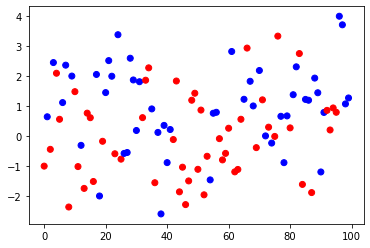

In [5]:
# mixture model
# ----------

# true unknown parameters:
theta_true1 = torch.Tensor([0.]) # , 0
theta_true2 = torch.Tensor([1.]) # , 0.1
 
# assume we know the true covariance matrix:
sigma = torch.ones(1)*np.sqrt(2) #torch.eye(1) # --> variance=2

# sample data
torch.manual_seed(2)

# mix = dist.Categorical(torch.ones(2,))
# locations = torch.tensor([theta_true1,  theta_true1 + theta_true2])
# components = dist.Normal(locations, torch.ones(2))
# gmm = dist.MixtureSameFamily(mix, components)
# gmm_data = gmm.sample(torch.Size([1000]))

n_data=100
z = torch.distributions.Bernoulli(probs=torch.Tensor([0.5])).sample(torch.Size([n_data]))
normal1 = dist.Normal(theta_true1, sigma)
normal2 = dist.Normal(theta_true1 + theta_true2, sigma)

# simulate data:
gmm_data = torch.zeros(n_data, 1)

for i in range(n_data):
    if z[i] == 0:
        gmm_data[i] = normal1.sample()
    else:
        gmm_data[i] = normal2.sample()


# set exactly equal/not required
gmm_data[z==0] = (gmm_data[z==0] - gmm_data[z==0].mean()) / gmm_data[z==0].std() * sigma + theta_true1
gmm_data[z==1] = (gmm_data[z==1] - gmm_data[z==1].mean()) / gmm_data[z==1].std() * sigma + (theta_true1 + theta_true2)

plt.scatter(x=range(n_data), y=gmm_data.reshape(-1), color=np.where(z.numpy().reshape(-1) == 0, "r", "b"))
plt.show()

In [6]:

print("---- Data stats ----")
print(f"mean={gmm_data.mean()}, sd={gmm_data.std()}", end="\n\n")

print("---- Group 1 stats ----")
print(f"n={(z==0).sum()}, mean={gmm_data[z==0].mean()}, var={gmm_data[z==0].var()}", end="\n\n")

print("---- Group 2 stats ----")
print(f"n={(z==1).sum()}, mean={gmm_data[z==1].mean()}, var={gmm_data[z==1].var()}")


---- Data stats ----
mean=0.49000003933906555, sd=1.4940623044967651

---- Group 1 stats ----
n=51, mean=2.3374370883288975e-08, var=1.9999998807907104

---- Group 2 stats ----
n=49, mean=0.9999999403953552, var=2.0


In [7]:
def mixture_loglikelihood(theta_vec, data):
    mix = dist.Categorical(torch.ones(2,))
    loc = torch.tensor([theta_vec[0][0], theta_vec[0][0]+theta_vec[0][1]])
    scale = torch.ones(2)*sigma # known <- this has to be standard deviation!!
    comp = dist.Normal(loc, scale)
    gmm = dist.MixtureSameFamily(mix, comp)
    return gmm.log_prob(data).sum()  #axis=-1


def mixture_logprior(theta_vec):
    # prior on thetas
    mu0 = torch.zeros(2)
    sigma0 = torch.Tensor([[10, 0], [0, 1]]) #torch.eye(2)*10
    
    normal_prior = torch.distributions.MultivariateNormal(loc=mu0, covariance_matrix=sigma0)
    # thetas are independent, so sum
    return normal_prior.log_prob(theta_vec).sum() #axis=-1


def gmm_potential(theta_vec, data, batch_size=None):
    # theta1, theta2 = x[0][0].reshape(1), x[0][1].reshape(1)
    
    if batch_size is not None:
        data_sub = data[np.random.randint(0, len(data), size=batch_size)]
        return mixture_logprior(theta_vec) + data.shape[0]/batch_size * mixture_loglikelihood(theta_vec, data_sub)
    else: 
        return mixture_logprior(theta_vec) + mixture_loglikelihood(theta_vec, data)
    #print(f"Data shape--{data_sub.shape}")
    

In [8]:
MALA = partial(
    Langevin_MC,
    skip_MH=False, # explicitly
    burnin_percent=.1,
    D=2,
)

ULA = partial(
    Langevin_MC,
    skip_MH=True, # explicitly
    burnin_percent=.1,
    D=2,
)

In [9]:
torch.manual_seed(11)
samples_gmm_mala_1e3 = MALA(
    partial(gmm_potential, data=gmm_data), 
    step=lambda x: 1e-3, 
    n_samples=int(1e4), 
    thining_percent=1,
)

x_0=tensor([[0.7376, 1.9459]])
0/10000 ... step size = 0.001; log posterior = -213.20457458496094
1000/10000 ... step size = 0.001; log posterior = -184.97579956054688
2000/10000 ... step size = 0.001; log posterior = -186.00596618652344
3000/10000 ... step size = 0.001; log posterior = -184.84878540039062
4000/10000 ... step size = 0.001; log posterior = -185.00975036621094
5000/10000 ... step size = 0.001; log posterior = -185.34744262695312
6000/10000 ... step size = 0.001; log posterior = -185.91212463378906
7000/10000 ... step size = 0.001; log posterior = -189.88372802734375
8000/10000 ... step size = 0.001; log posterior = -185.68707275390625
9000/10000 ... step size = 0.001; log posterior = -185.61370849609375
10000/10000 ... step size = 0.001; log posterior = -185.42462158203125
rejections=11.25%


In [10]:
torch.manual_seed(121)
samples_gmm_mala_1e2 = MALA(
    partial(gmm_potential, data=gmm_data), 
    step=lambda x: 1e-2, 
    n_samples=int(1e4), 
    thining_percent=1,
)

x_0=tensor([[1.4521, 0.0504]])
0/10000 ... step size = 0.01; log posterior = -209.25257873535156
1000/10000 ... step size = 0.01; log posterior = -185.29611206054688
2000/10000 ... step size = 0.01; log posterior = -185.27792358398438
3000/10000 ... step size = 0.01; log posterior = -185.53636169433594
4000/10000 ... step size = 0.01; log posterior = -185.04283142089844
5000/10000 ... step size = 0.01; log posterior = -185.6033477783203
6000/10000 ... step size = 0.01; log posterior = -184.84422302246094
7000/10000 ... step size = 0.01; log posterior = -184.8717041015625
8000/10000 ... step size = 0.01; log posterior = -185.09286499023438
9000/10000 ... step size = 0.01; log posterior = -184.87660217285156
10000/10000 ... step size = 0.01; log posterior = -185.22076416015625
rejections=31.67%


In [11]:
torch.manual_seed(121)
samples_gmm_ula_1e4 = ULA(
    partial(gmm_potential, data=gmm_data), 
    step=lambda x: 1e-4, 
    n_samples=int(2e4), 
    thining_percent=1,
)

x_0=tensor([[1.4521, 0.0504]])
0/20000 ... step size = 0.0001; log posterior = -209.25257873535156
2000/20000 ... step size = 0.0001; log posterior = -309.7573547363281
4000/20000 ... step size = 0.0001; log posterior = -231.93519592285156
6000/20000 ... step size = 0.0001; log posterior = -189.22076416015625
8000/20000 ... step size = 0.0001; log posterior = -189.21804809570312
10000/20000 ... step size = 0.0001; log posterior = -187.16156005859375
12000/20000 ... step size = 0.0001; log posterior = -210.72657775878906
14000/20000 ... step size = 0.0001; log posterior = -221.28134155273438
16000/20000 ... step size = 0.0001; log posterior = -194.11192321777344
18000/20000 ... step size = 0.0001; log posterior = -188.0157470703125
20000/20000 ... step size = 0.0001; log posterior = -204.1320343017578
rejections=0.0%


In [12]:
torch.manual_seed(121)
samples_gmm_ula_1e3 = ULA(
    partial(gmm_potential, data=gmm_data), 
    step=lambda x: 1e-3, 
    n_samples=int(2e4), 
    thining_percent=1,
)

x_0=tensor([[1.4521, 0.0504]])
0/20000 ... step size = 0.001; log posterior = -209.25257873535156
2000/20000 ... step size = 0.001; log posterior = -562.3770141601562
4000/20000 ... step size = 0.001; log posterior = -208.3877716064453
6000/20000 ... step size = 0.001; log posterior = -189.08778381347656
8000/20000 ... step size = 0.001; log posterior = -266.962646484375
10000/20000 ... step size = 0.001; log posterior = -207.31614685058594
12000/20000 ... step size = 0.001; log posterior = -519.8316040039062
14000/20000 ... step size = 0.001; log posterior = -487.39801025390625
16000/20000 ... step size = 0.001; log posterior = -218.44793701171875
18000/20000 ... step size = 0.001; log posterior = -200.60189819335938
20000/20000 ... step size = 0.001; log posterior = -552.2726440429688
rejections=0.0%


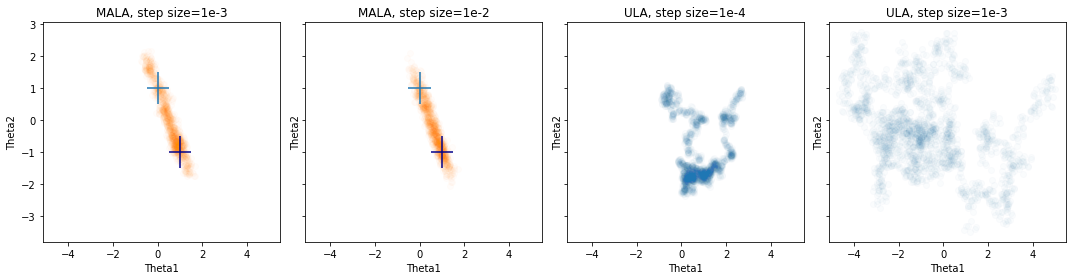

In [15]:
thinning=10
fix, ax = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)

ax[0].scatter(
    samples_gmm_mala_1e3[:, 0][::thinning], 
    samples_gmm_mala_1e3[:, 1][::thinning], #+samples_gmm_mala_1e3[:, 0][::2] 
    marker="o", alpha=.02, color="darkorange")
ax[0].set_title("MALA, step size=1e-3")
ax[0].set_xlabel("Theta1")
ax[0].set_ylabel("Theta2")
ax[0].hlines([1], -.5, 0.5)
ax[0].vlines([0], 0.5, 1.5)
ax[0].hlines([-1], 0.5, 1.5, color="darkblue")
ax[0].vlines([1], -1.5, -0.5, color="darkblue")

ax[1].scatter(
    samples_gmm_mala_1e2[:, 0][::thinning], 
    samples_gmm_mala_1e2[:, 1][::thinning], 
    marker="o", alpha=.02, color="darkorange")
ax[1].set_title("MALA, step size=1e-2")
ax[1].set_xlabel("Theta1")
ax[1].set_ylabel("Theta2")
ax[1].hlines([1], -.5, 0.5)
ax[1].vlines([0], 0.5, 1.5)
ax[1].hlines([-1], 0.5, 1.5, color="darkblue")
ax[1].vlines([1], -1.5, -0.5, color="darkblue")

ax[2].scatter(samples_gmm_ula_1e4[:, 0][::thinning], samples_gmm_ula_1e4[:, 1][::thinning], marker="o", alpha=.02)
ax[2].set_title("ULA, step size=1e-4")
ax[2].set_xlabel("Theta1")
ax[2].set_ylabel("Theta2")

ax[3].scatter(samples_gmm_ula_1e3[:, 0][::thinning], samples_gmm_ula_1e3[:, 1][::thinning], marker="o", alpha=.02)
ax[3].set_title("ULA, step size=1e-3")
ax[3].set_xlabel("Theta1")
ax[3].set_ylabel("Theta2")

plt.tight_layout()
plt.show()

-----

In [16]:
step=partial(step_function, gamma=0.55, a=.01, b=1000)
print(f"step size from {step(0)} to {step(int(1e5))}")

# stoch grad
batch_size=8
SGLD = partial(
    Langevin_MC, 
    n_samples=int(1e5),
    skip_MH=True, 
    D=2,
    burnin_percent=.1,
)

torch.manual_seed(11)
sgld_samples = SGLD(
    partial(gmm_potential, data=gmm_data, batch_size=batch_size), 
    step=step,
)

sgld_samples_const_step = SGLD(
    partial(gmm_potential, data=gmm_data, batch_size=batch_size), 
    step=lambda x: 1e-4,
)

step size from 0.0002238721138568339 to 1.7685740338172434e-05
x_0=tensor([[0.7376, 1.9459]])
0/100000 ... step size = 0.00022; log posterior = -203.67855834960938
10000/100000 ... step size = 6e-05; log posterior = -202.70443725585938
20000/100000 ... step size = 4e-05; log posterior = -160.2495574951172
30000/100000 ... step size = 3e-05; log posterior = -245.73060607910156
40000/100000 ... step size = 3e-05; log posterior = -254.1570281982422
50000/100000 ... step size = 3e-05; log posterior = -256.2209777832031
60000/100000 ... step size = 2e-05; log posterior = -193.9857177734375
70000/100000 ... step size = 2e-05; log posterior = -182.25343322753906
80000/100000 ... step size = 2e-05; log posterior = -202.54888916015625
90000/100000 ... step size = 2e-05; log posterior = -198.01284790039062
100000/100000 ... step size = 2e-05; log posterior = -198.3413848876953
rejections=0.0%
x_0=tensor([[-2.2036, -1.1188]])
0/100000 ... step size = 1e-05; log posterior = -417.96466064453125
100

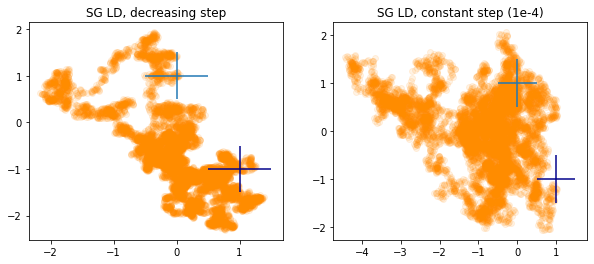

In [21]:
fix, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(sgld_samples[:, 0][::10], sgld_samples[:, 1][::10], marker="o", alpha=.1, color="darkorange")
ax[0].set_title("SG LD, decreasing step")
ax[0].hlines([1], -.5, 0.5)
ax[0].vlines([0], 0.5, 1.5)
ax[0].hlines([-1], 0.5, 1.5, color="darkblue")
ax[0].vlines([1], -1.5, -0.5, color="darkblue")

ax[1].scatter(sgld_samples_const_step[:, 0][::10], sgld_samples_const_step[:, 1][::10], marker="o", alpha=.1, color="darkorange")
ax[1].set_title("SG LD, constant step (1e-4)")
ax[1].hlines([1], -.5, 0.5)
ax[1].vlines([0], 0.5, 1.5)
ax[1].hlines([-1], 0.5, 1.5, color="darkblue")
ax[1].vlines([1], -1.5, -0.5, color="darkblue")

plt.show()